# AI Ethics integration with KFServing

## KFServing

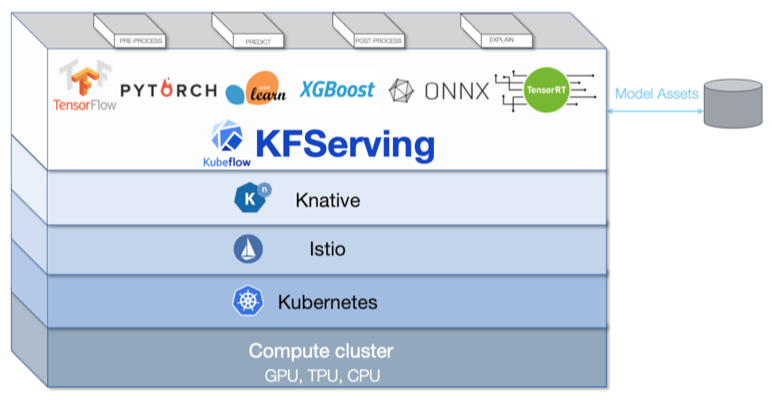

# AIF360 on KFServing

This is an example for how to produce model fairness metrics using AIF360 on KFServing. We will be using the [german-credit](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)), dataset for good or bad credit risks, for this model and produce the model fairness metrics on the predictions.

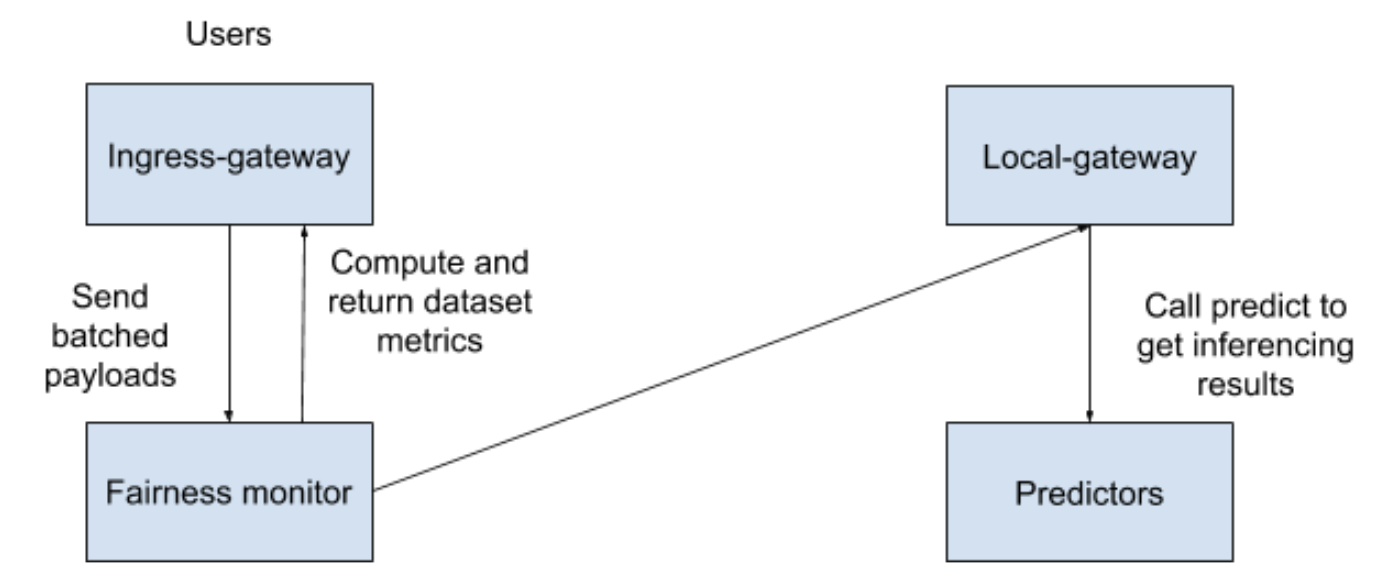

In [ ]:
## Initial cluster variables
## Update the kubeflow_url to your Kubeflow dashboard endpoint if it's running on a remote cluster.

import os
kubeflow_url = 'istio-ingressgateway.istio-system'
os.environ["kubeflow_url"] = kubeflow_url

In [ ]:
import textwrap
aix_yaml = textwrap.dedent("""
apiVersion: serving.kubeflow.org/v1alpha2
kind: InferenceService
metadata:
  labels:
    controller-tools.k8s.io: "1.0"
  name: german-credit
spec:
  default:
    predictor:
      custom:
        container:
          image: rzgry/german-credit
    explainer:
      custom:
        container:
          name: explainer
          image: tomcli/aifserver:latest
          command:
            [
              "python",
              "-m",
              "aifserver",
              "--predictor_host",
              "german-credit-predictor-default.anonymous.svc.cluster.local",
              "--model_name",
              "german-credit",
              "--feature_names",
              "age",
              "sex",
              "credit_history=Delay",
              "credit_history=None/Paid",
              "credit_history=Other",
              "savings=500+",
              "savings=<500",
              "savings=Unknown/None",
              "employment=1-4 years",
              "employment=4+ years",
              "employment=unemployed",
              "--label_names",
              "credit",
              "--favorable_label",
              "1",
              "--unfavorable_label",
              "2",
              "--privileged_groups",
              '{"age": 1}',
              "--unprivileged_groups",
              '{"age": 0}',
            ]
          imagePullPolicy: Always
          resources:
            requests:
              memory: "2Gi"
              cpu: "2"
            limits:
              memory: "2Gi"
              cpu: "2"
""")
f = open("aif.yaml", "w")
f.write(aix_yaml)
f.close()

In [ ]:
!kubectl apply -f aif.yaml

In [ ]:
!kubectl get pod | grep german-credit
!kubectl get inferenceservice german-credit

In [ ]:
## Initial variables and helper functions
import requests
import json

model_name = 'german-credit'
payload={
  "instances": [
    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
  ]
}

def model_inference(model_name, kubeflow_url, request, method='predict'):
    headers = {
        'Host': model_name + ".anonymous.example.com"
    }
    model_url = kubeflow_url + "/v1/models/" + model_name + ":" + method
    response = requests.post('http://' + model_url, json=request, headers=headers)
    res = json.loads(response.text)
    print(json.dumps(res['metrics'], indent=2))

In [ ]:
model_inference(model_name, kubeflow_url, payload, method='explain')

## Output metrics

| Name                          | Description                                                                                                 |
| ----------------------------- | ----------------------------------------------------------------------------------------------------------- |
| base_rate                     | (float): Compute the base rate, 𝑃𝑟(𝑌=1)=𝑃/(𝑃+𝑁)                                                             |
| consistency                   | (list): Individual fairness metric from [1] that measures how similar the labels are for similar instances. |
| disparate_impact              | (float): 𝑃𝑟(𝑌=1 \| 𝐷=unprivileged)𝑃𝑟(𝑌=1 \| 𝐷=privileged)                                                   |
| num_instances                 | (float): Compute the number of instances n                                                                  |
| num_negatives                 | (float): Compute the number of negatives, 𝑁=∑𝑛𝑖=1𝟙[𝑦𝑖=0]                                                    |
| num_positives                 | (float): Compute the number of positives, 𝑃=∑𝑛𝑖=1𝟙[𝑦𝑖=1]                                                    |
| statistical_parity_difference | (float): 𝑃𝑟(𝑌=1\|𝐷=unprivileged)−𝑃𝑟(𝑌=1\|𝐷=privileged)                                                      |

# AI Ethics on Kubeflow pipeline

In [ ]:
import json
from kfp import components
import kfp.dsl as dsl


katib_experiment_launcher_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml')
fairness_check_ops = components.load_component_from_url('https://raw.githubusercontent.com/Trusted-AI/AIF360/master/mlops/kubeflow/bias_detector_pytorch/component.yaml')
robustness_check_ops = components.load_component_from_url('https://raw.githubusercontent.com/Trusted-AI/adversarial-robustness-toolbox/main/utils/mlops/kubeflow/robustness_evaluation_fgsm_pytorch/component.yaml')


@dsl.pipeline(
    name="Launch trusted-ai pipeline",
    description="An example for trusted-ai integration."
)
def trusted_ai(
        name="trusted-ai",
        namespace="anonymous",
        goal="0.99",
        parallelTrialCount="1",
        maxTrialCount="1",
        experimentTimeoutMinutes="60",
        deleteAfterDone="True",
        fgsm_attack_epsilon='0.2',
        model_class_file='PyTorchModel.py',
        model_class_name='ThreeLayerCNN',
        feature_testset_path='processed_data/X_test.npy',
        label_testset_path='processed_data/y_test.npy',
        protected_label_testset_path='processed_data/p_test.npy',
        favorable_label='0.0',
        unfavorable_label='1.0',
        privileged_groups="[{'race': 0.0}]",
        unprivileged_groups="[{'race': 4.0}]",
        loss_fn='torch.nn.CrossEntropyLoss()',
        optimizer='torch.optim.Adam(model.parameters(), lr=0.001)',
        clip_values='(0, 1)',
        nb_classes='2',
        input_shape='(1,3,64,64)'):
    objectiveConfig = {
      "type": "maximize",
      "goal": goal,
      "objectiveMetricName": "accuracy",
      "additionalMetricNames": []
    }
    algorithmConfig = {"algorithmName" : "random"}
    parameters = [
      {"name": "--dummy", "parameterType": "int", "feasibleSpace": {"min": "1", "max": "2"}},
    ]
    rawTemplate = {
      "apiVersion": "batch/v1",
      "kind": "Job",
      "metadata": {
         "name": "{{.Trial}}",
         "namespace": "{{.NameSpace}}"
      },
      "spec": {
        "template": {
          "spec": {
            "restartPolicy": "Never",
            "containers": [
              {"name": "{{.Trial}}",
               "image": "aipipeline/gender-classification:latest",
               "command": [
                   "python", "-u", "gender_classification_training.py", "--data_bucket", "mlpipeline", "--result_bucket", "mlpipeline"
               ]
              }
            ],
            "env": [{'name': 'S3_ENDPOINT', 'value': 'minio-service.kubeflow:9000'}]
          }
        }
      }
    }
    trialTemplate = {
      "goTemplate": {
        "rawTemplate": json.dumps(rawTemplate)
      }
    }
    katib_run = katib_experiment_launcher_op(
        experiment_name=name,
        experiment_namespace=namespace,
        parallel_trial_count=parallelTrialCount,
        max_trial_count=maxTrialCount,
        objective=str(objectiveConfig),
        algorithm=str(algorithmConfig),
        trial_template=str(trialTemplate),
        parameters=str(parameters),
        experiment_timeout_minutes=experimentTimeoutMinutes,
        delete_finished_experiment=deleteAfterDone)

    fairness_check = fairness_check_ops(model_id='training-example',
                                        model_class_file=model_class_file,
                                        model_class_name=model_class_name,
                                        feature_testset_path=feature_testset_path,
                                        label_testset_path=label_testset_path,
                                        protected_label_testset_path=protected_label_testset_path,
                                        favorable_label=favorable_label,
                                        unfavorable_label=unfavorable_label,
                                        privileged_groups=privileged_groups,
                                        unprivileged_groups=unprivileged_groups,
                                        data_bucket_name='mlpipeline',
                                        result_bucket_name='mlpipeline').after(katib_run).set_image_pull_policy("Always")
    robustness_check = robustness_check_ops(model_id='training-example',
                                            epsilon=fgsm_attack_epsilon,
                                            model_class_file=model_class_file,
                                            model_class_name=model_class_name,
                                            feature_testset_path=feature_testset_path,
                                            label_testset_path=label_testset_path,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            clip_values=clip_values,
                                            nb_classes=nb_classes,
                                            input_shape=input_shape,
                                            data_bucket_name='mlpipeline',
                                            result_bucket_name='mlpipeline').after(katib_run).set_image_pull_policy("Always")

In [ ]:
import kfp
import kfp.compiler as compiler

client = kfp.Client()
EXPERIMENT_NAME = 'KFServing Experiments'
experiment = client.create_experiment(name=EXPERIMENT_NAME)
compiler.Compiler().compile(trusted_ai, 'trusted-ai.tar.gz')
# Execute pipeline
run = client.run_pipeline(experiment.id, 'trusted-ai', 'trusted-ai.tar.gz')

**Fairness Metrics**
- **Classification accuracy**: Amount of correct predictions using the test data. Ideal value: 1
- **Balanced classification accuracy**: Balanced true positive and negative predictions (0.5*(TPR+TNR)) using the test data. Ideal value: 1
- **Statistical parity difference**: Difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. Ideal value: 0 (-0.1 to 0.1 will consider as fair)
- **Disparate impact**: The ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. Ideal value: 1 (0.8 to 1.2 will consider as fair)
- **Equal opportunity difference**: Difference of true positive rates between the unprivileged and the privileged groups. Ideal value: 0 (-0.1 to 0.1 will consider as fair)
- **Average odds difference**: Average difference of false positive rate (false positives / negatives) and true positive rate (true positives / positives) between unprivileged and privileged groups. Ideal value: 0 (-0.1 to 0.1 will consider as fair)
- **Theil index**: Generalized entropy of benefit for all individuals in the dataset. It measures the inequality in benefit allocation for individuals. Ideal value: 0 (0 is the perfect fairness, there's no concrete interval to be considered as fair for this metric)
- **False negative rate difference**: Difference of false negative rate between unprivileged and privileged instances. Ideal value: 0 (-0.1 to 0.1 will consider as fair)

**Robustness Metrics**
- **Model accuracy on test data**: Amount of correct predictions using the original test data. Ideal value: 1
- **Model accuracy on adversarial samples**: Amount of correct predictions using the adversarial test samples. Ideal value: 1
- **Reduction in confidence**: Average amount of confidence score get reduced. Ideal value: 0
- **Average perturbation**: Average amount of [adversarial changes](https://en.wikipedia.org/wiki/Perturbation_theory) needed to make in order to fool the classifier. Ideal value: 1

# Clean up

In [ ]:
!kubectl delete inferenceservice aixserver german-credit